# Comparative Analysis of the 50 States and D.C.

## This Notebook will analyze various political / demographic variables in all 50 states + D.C.
### This dataset (provided by the political data website FiveThirtyEight.com) includes information such as political leanings, racial demographics, immigration, hate crimes, poverty, wealth inequality, and education.

### Import all relevant libraries (there's a LOT.)

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import requests
import scipy.stats as stats
import math
import csv
from io import StringIO

### Get the needed CSV data from FiveThirtyEight's Github repository.

In [2]:
url = "https://raw.githubusercontent.com/fivethirtyeight/data/master/hate-crimes/hate_crimes.csv"
response = requests.get(url)
csv_data = response.text
reader = csv.DictReader(StringIO(csv_data))
dataset = list(reader)

## Clean the data by replacing all empty strings with a zero in order to allow math/visualization later on
#### Some entries in the data had an empty string ' ' instead of a number, and we cannot do math on an empty string or convert it to a number, so this code will ensure that our code will not be broken by attempting to perform numerical operations on strings.

In [3]:
count = 0
for state in dataset:
    for term in state:
        if state[term] == "NaN":
            print("Removed a broken data piece.")
            state[term] = 0
        if state[term] == "":
            state[term] = 0
            count += 1
print("Successfully replaced %s empty strings." % count)

Successfully replaced 8 empty strings.


### Open up the first data entry to see which variables are available in this dataset.

In [4]:
dataset[0]

{'state': 'Alabama',
 'median_household_income': '42278',
 'share_unemployed_seasonal': '0.06',
 'share_population_in_metro_areas': '0.64',
 'share_population_with_high_school_degree': '0.821',
 'share_non_citizen': '0.02',
 'share_white_poverty': '0.12',
 'gini_index': '0.472',
 'share_non_white': '0.35',
 'share_voters_voted_trump': '0.63',
 'hate_crimes_per_100k_splc': '0.125838926',
 'avg_hatecrimes_per_100k_fbi': '1.806410489'}

### Define some useful functions that will help us later.

In [5]:
def getList(term):
    return [float(d[term]) for d in dataset]

def avgOfList(term):
    list = getList(term)
    sum = 0
    for i in list:
        sum+=float(i)
    return sum / len(list)

def maxOfList(term):
    list = getList(term)
    max = 0
    for i in list:
        if i>max:
            max=i
    return max

def minOfList(term):
    list = getList(term)
    min = 10**15
    for i in list:
        if i<min and i!=0:
            min=i
    return min

def getStateWithStat(term,value):
    chosen = "N/A"
    for state in dataset:
        if str(state[term]) == str(value):
            chosen = state['state']
    return chosen

def getMeanList(xterm,yterm): # This function will make a "list" to graph the mean data point later on
    yAvg = avgOfList(yterm)
    xAvg = avgOfList(xterm)
    xlist = [minOfList(xterm),maxOfList(xterm)]
    ylist = [yAvg,yAvg]
    xlist2 = [xAvg,xAvg]
    ylist2 = [minOfList(yterm),maxOfList(yterm)]
    return xAvg,yAvg,xlist,ylist,xlist2,ylist2

def getColor(set):
    trumprate = float(set['share_voters_voted_trump'])
    myColor = "#dd77dd"
    if trumprate >= .6:
        myColor = "#ff0000"
    elif trumprate >= 0.53:
        myColor = "#ff7777"
    elif trumprate <= .4:
        myColor = "#0000ff"
    elif trumprate <= 0.47:
        myColor = "#9999ff"
    return myColor

globalColors = [getColor(set) for set in dataset]

### Define a function to round numbers, making them more beautiful when presenting

In [6]:
def round(num,digits):
    digits = digits or 3
    power = 10 ** digits
    return (math.ceil(num * power)) / power

### Display some statistics about the GINI index (wealth inequality) by state, as well as the relative rates of hate crimes as defined by (1) the Southern Poverty Law Center and (2) the Federal Bureau of Investigation (FBI).

In [7]:
def showStat(term,statType,value,state="N/A"):
    print("The %s of [%s] is:   %s (%s)"  % (statType,term,round(value,6),state))
    
def showStats(term):
    print("")
    showStat(term,"MEAN",avgOfList(term))
    showStat(term,"MAXIMUM",maxOfList(term),getStateWithStat(term,maxOfList(term)))
    showStat(term,"MINIMUM",minOfList(term),getStateWithStat(term,minOfList(term)))
    print("")
    
showStats("gini_index")
showStats("hate_crimes_per_100k_splc")
showStats("avg_hatecrimes_per_100k_fbi")


The MEAN of [gini_index] is:   0.453765 (N/A)
The MAXIMUM of [gini_index] is:   0.532 (District of Columbia)
The MINIMUM of [gini_index] is:   0.419 (Utah)


The MEAN of [hate_crimes_per_100k_splc] is:   0.280243 (N/A)
The MAXIMUM of [hate_crimes_per_100k_splc] is:   1.522302 (District of Columbia)
The MINIMUM of [hate_crimes_per_100k_splc] is:   0.067447 (Mississippi)


The MEAN of [avg_hatecrimes_per_100k_fbi] is:   2.32119 (N/A)
The MAXIMUM of [avg_hatecrimes_per_100k_fbi] is:   10.95348 (District of Columbia)
The MINIMUM of [avg_hatecrimes_per_100k_fbi] is:   0.266941 (Wyoming)



### Define a function (for later use) that will allow us to plot two variables against each other by just inputting each variable's name (from the Dataset)

In [8]:
def draw(xName,yName):
    X = np.array(getList(xName))
    Y = np.array(getList(yName))
    slope, intercept, r_value, p_value, std_err = stats.linregress(X,Y)
    a,b = np.polyfit(X,Y,1)
    plt.xlabel(xName)
    plt.ylabel(yName)
    plt.title("%s     vs.     %s\n\na = %s     b = %s     r = %s     r^2 = %s\n\nmean x = %s     mean y = %s" % (yName,xName,round(a,7),round(b,5),round(r_value,4),round(r_value ** 2,4),round(avgOfList(xName),3),round(avgOfList(yName),3)))
    # Make the scatterplot
    plt.scatter(X,Y,s=40,c=globalColors,edgecolors='#000000')
    #Make the best fit line
    plt.plot(X,a*X+b,c='#ff4444',linewidth=2,alpha=0.5,label="Best Fit Line")
    # Plot mean lines
    yAvg,xAvg,xList,yList,xList2,yList2 = getMeanList(xName,yName)
    plt.plot(xList,yList,linewidth=2,linestyle="--",color="#44cc44",alpha=0.5,label="MEAN %s" % yName)
    plt.plot(xList2,yList2,linewidth=2,linestyle="--",color="#4444cc",alpha=0.5,label="MEAN %s" % xName)
    #Add the legend
    leg = plt.legend(loc='best')
    #Render the graph
    plt.show()

# Start drawing some graphs!!!
### Note: Each dot represents a U.S. state, colored according to its political leanings as of the 2020 presidential election. Blue = Democrat, Red = Republican, Magenta = Swing State
### Be aware that some data values were missing in the initial dataset, so a state may have a default value of "zero" in one or more category despite not actually having that value.


### Here we will compare hate crime reports as categorized by the FBI and the SPLC.
##### Notice that the slope of the best-fit line is about 0.102, meaning that for every ~10 hate crimes reported by the FBI, the Southern Poverty Law Center only reports 1. This may suggest an intentional underreporting of hate crimes.

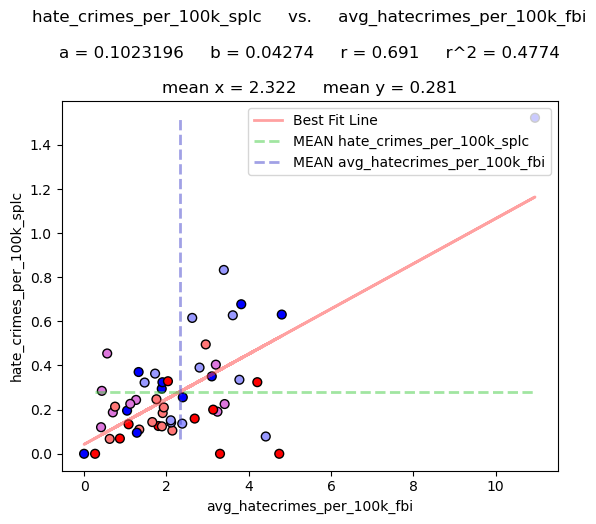

In [9]:
draw("avg_hatecrimes_per_100k_fbi","hate_crimes_per_100k_splc")

### Now we will compare election results (based on the % of the vote Trump won) to the share of non-white residents in each state
##### There is not a very good correlation, but one major outlier causes a skew in the best-fit line making it seem like there is a correlation between voting demographics and share of non-white residents.

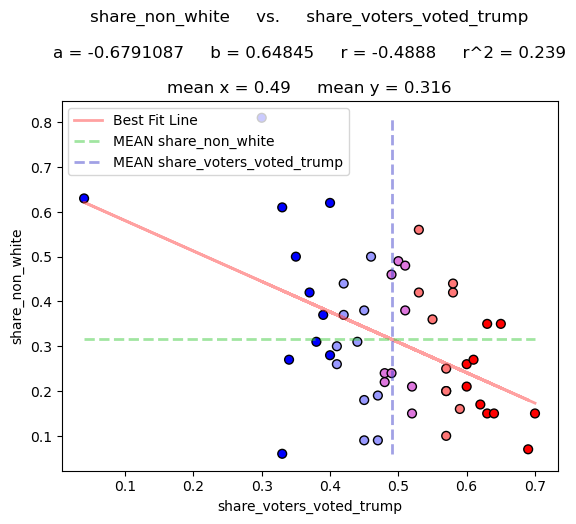

In [10]:
draw('share_voters_voted_trump','share_non_white')

### Now, we compare the share of non-white residents in each state to the share of non-citizens.
#### We see a pretty strong (r=0.7014) positive correlation between these two variables, as one might expect, since many non-citizen immigrants come from countries that are predominantly non-white.

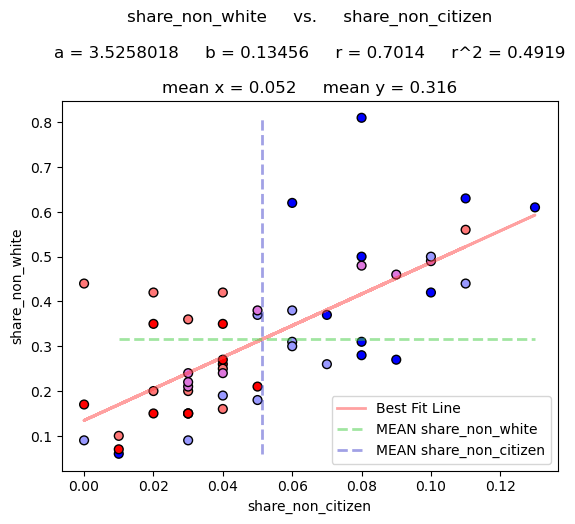

In [11]:
draw('share_non_citizen','share_non_white')

### Now let's compare metro (city/urban) population share to high school education rates.
#### A very unusual pattern emerges here. We see that more metropolitan (urban) states, which tend to be more Democratic, have more moderate rates of high school education. However, in rural states, the divide is much more severe. The most educated AND most uneducated states are the rural ones. None of the rural states have a near-average high school education rate. I am not sure why this is.

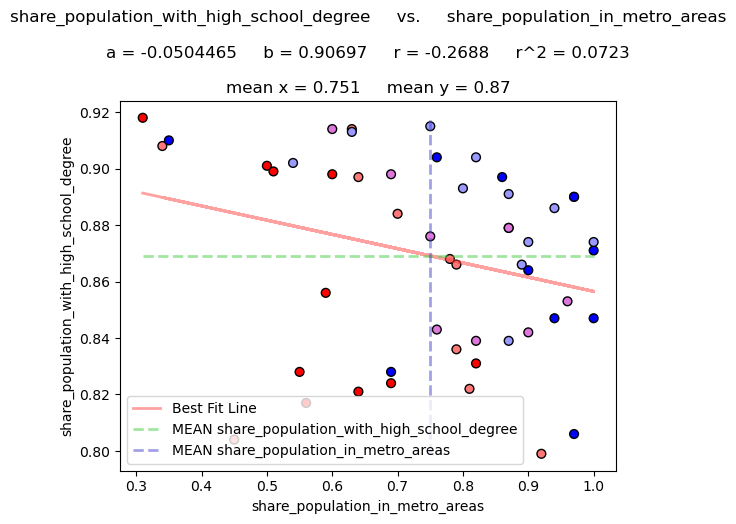

In [12]:
draw('share_population_in_metro_areas','share_population_with_high_school_degree')

### Now we will compare high school education to the GINI (wealth inequality) index!
#### As expected, states with more high school-educated residents generally have less wealth inequality, since education is a major factor in social mobility.
#### The correlation coefficient (r) is -0.592, which is fairly moderate, meaning that there is definitely an approximate correlation between high school education and wealth inequality.

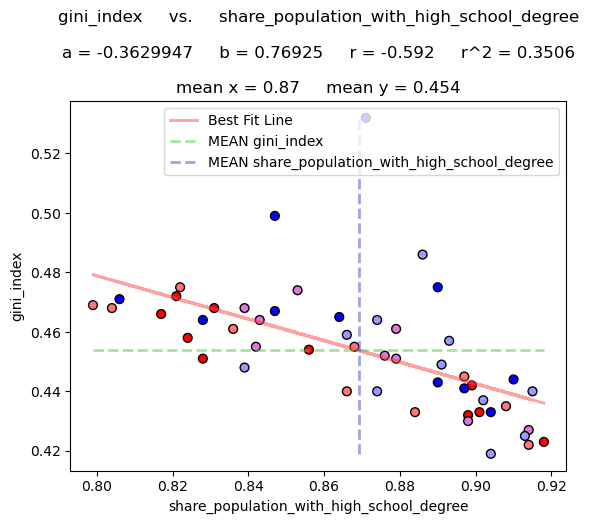

In [13]:
draw('share_population_with_high_school_degree','gini_index')

# All done!
### We have found some pretty interesting trends by analyzing this data numerically as well as graphically (visually).